<a href="https://colab.research.google.com/github/malraharsh/Pruning-Experiments/blob/master/Pruning_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q tensorflow-model-optimization

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
import pandas as pd

from tensorflow import keras

%load_ext tensorboard

os.mkdir('log')

In [3]:
SHOW = False

In [ ]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(Train_images, Train_labels), (Test_images, Test_labels) = mnist.load_data()

# pct_data = 0.1
# top = int(np.ceil(Train_images.shape[0] * pct_data))

# (train_images, train_labels), (test_images, test_labels) = (Train_images[:top], Train_labels[:top]), (Test_images[:top], Test_labels[:top])
# print(top)

In [17]:
train_images = train_labels = test_images = test_labels = None

def change_pct_data(pct_data):    
    global train_images, train_labels, test_images, test_labels    
    top = int(np.ceil(Train_images.shape[0] * pct_data))
    (train_images, train_labels), (test_images, test_labels) = (Train_images[:top], Train_labels[:top]), (Test_images[:top], Test_labels[:top])
    print(f"No of data - {top}")

In [ ]:
def train(train_images, train_labels, test_images, test_labels):

    # Normalize the input image so that each pixel value is between 0 to 1.
    train_images = train_images.copy() / 255.0
    test_images = test_images.copy() / 255.0

    # Define the model architecture.
    model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28)),
    keras.layers.Reshape(target_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
    ])

    # Train the digit classification model
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    history = model.fit(
    train_images,
    train_labels,
    epochs=1,
    validation_split=0.1,
    )
    if SHOW:
        _, baseline_test_accuracy = model.evaluate(
        test_images, test_labels, verbose=0)

        _, baseline_train_accuracy = model.evaluate(
        train_images, train_labels, verbose=0)

        print('Baseline train accuracy:', baseline_train_accuracy*100)

        print('Baseline test accuracy:', baseline_test_accuracy*100)

        print('Baseline difference:', (baseline_train_accuracy - baseline_test_accuracy)*100)

    return model, history
    

def prune(train_images, train_labels, model):

    # Compute end step to finish pruning after 2 epochs.
    batch_size = 128
    epochs = 1
    validation_split = 0.1 # 10% of training set will be used for validation set. 

    num_images = train_images.shape[0] * (1 - validation_split)
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                   final_sparsity=0.80,
                                                                   begin_step=0,
                                                                   end_step=end_step)
    }

    model_for_pruning = prune_low_magnitude(model, **pruning_params)

    # `prune_low_magnitude` requires a recompile.
    model_for_pruning.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model_for_pruning.summary()

    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
      tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
    ]

    model_for_pruning.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                      callbacks=callbacks)
    
    _, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

    print()
    print('Baseline test accuracy:', baseline_model_accuracy) 
    print('Pruned test accuracy:', model_for_pruning_accuracy)

In [ ]:
def do(test_pct):
    train_x, val_x, train_y, val_y = train_test_split(train_images, train_labels, test_size=test_pct, stratify=train_labels)
    model, history = train(train_x, train_y, val_x, val_y)
    return model, history

In [20]:
path_log = 'log/'

In [ ]:
def add_info(dic, pct, info):
    dic = {k:v[-1] for k, v in dic.items()}
    dic['percentage'] = pct
    return info.append(dic, ignore_index=True)   

def full_pct_data(pct_data): #pct of full data
    change_pct_data(pct_data) 
    df_info = pd.DataFrame()

    for p in range(10, 99, 20):
        print(f'\n Percentage is {p} \n')

        test_p = 1 - p/100
        _, history = do(test_p)

        info = history.history
        df_info = add_info(info, 1 - test_p, df_info)

    df_info.to_csv(f'log/info-{pct_data*100}%.csv')
    df_info.plot.scatter(x='percentage', y='accuracy')
    # return df_info    

No of data - 6000

 Percentage is 10 

17/17 [==============================] - 0s 11ms/step - loss: 2.0273 - accuracy: 0.4167 - val_loss: 1.6819 - val_accuracy: 0.6667

 Percentage is 30 

51/51 [==============================] - 0s 6ms/step - loss: 1.5861 - accuracy: 0.6099 - val_loss: 0.9306 - val_accuracy: 0.7333

 Percentage is 50 

85/85 [==============================] - 0s 5ms/step - loss: 1.2924 - accuracy: 0.6930 - val_loss: 0.4958 - val_accuracy: 0.8700

 Percentage is 70 

119/119 [==============================] - 1s 5ms/step - loss: 1.0008 - accuracy: 0.7502 - val_loss: 0.4839 - val_accuracy: 0.8571

 Percentage is 90 

152/152 [==============================] - 1s 4ms/step - loss: 0.8674 - accuracy: 0.7735 - val_loss: 0.3640 - val_accuracy: 0.8981


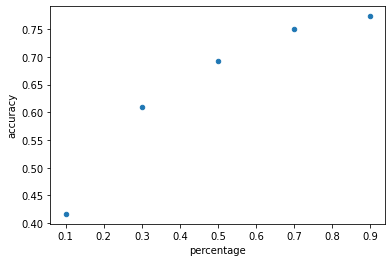

In [27]:
full_pct_data(0.1)

No of data - 12000

 Percentage is 10 

34/34 [==============================] - 0s 8ms/step - loss: 1.8347 - accuracy: 0.5500 - val_loss: 1.2840 - val_accuracy: 0.7833

 Percentage is 30 

102/102 [==============================] - 1s 7ms/step - loss: 1.1397 - accuracy: 0.7167 - val_loss: 0.4440 - val_accuracy: 0.8861

 Percentage is 50 

169/169 [==============================] - 1s 4ms/step - loss: 0.8307 - accuracy: 0.7856 - val_loss: 0.3844 - val_accuracy: 0.8917

 Percentage is 70 

237/237 [==============================] - 1s 4ms/step - loss: 0.7160 - accuracy: 0.8078 - val_loss: 0.3301 - val_accuracy: 0.8952

 Percentage is 90 

304/304 [==============================] - 1s 4ms/step - loss: 0.6045 - accuracy: 0.8323 - val_loss: 0.3661 - val_accuracy: 0.8880


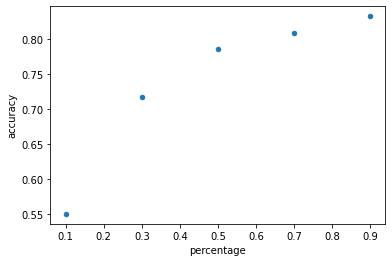

In [28]:
full_pct_data(0.2)

No of data - 30000

 Percentage is 10 

85/85 [==============================] - 0s 5ms/step - loss: 1.3450 - accuracy: 0.6796 - val_loss: 0.6018 - val_accuracy: 0.8700

 Percentage is 30 

254/254 [==============================] - 1s 4ms/step - loss: 0.6621 - accuracy: 0.8172 - val_loss: 0.3050 - val_accuracy: 0.9156

 Percentage is 50 

422/422 [==============================] - 2s 4ms/step - loss: 0.5421 - accuracy: 0.8522 - val_loss: 0.2979 - val_accuracy: 0.9127

 Percentage is 70 

591/591 [==============================] - 2s 4ms/step - loss: 0.4914 - accuracy: 0.8612 - val_loss: 0.3030 - val_accuracy: 0.9176

 Percentage is 90 

760/760 [==============================] - 3s 4ms/step - loss: 0.4458 - accuracy: 0.8748 - val_loss: 0.3080 - val_accuracy: 0.9078


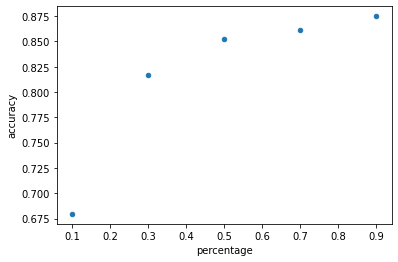

In [29]:
full_pct_data(0.5)

No of data - 42000

 Percentage is 10 

119/119 [==============================] - 1s 5ms/step - loss: 1.0653 - accuracy: 0.7225 - val_loss: 0.4619 - val_accuracy: 0.8619

 Percentage is 30 

355/355 [==============================] - 2s 5ms/step - loss: 0.6162 - accuracy: 0.8362 - val_loss: 0.2637 - val_accuracy: 0.9238

 Percentage is 50 

591/591 [==============================] - 2s 4ms/step - loss: 0.4811 - accuracy: 0.8626 - val_loss: 0.2726 - val_accuracy: 0.9186

 Percentage is 70 

827/827 [==============================] - 3s 4ms/step - loss: 0.4270 - accuracy: 0.8812 - val_loss: 0.2472 - val_accuracy: 0.9259

 Percentage is 90 

1064/1064 [==============================] - 4s 4ms/step - loss: 0.3894 - accuracy: 0.8914 - val_loss: 0.1978 - val_accuracy: 0.9418


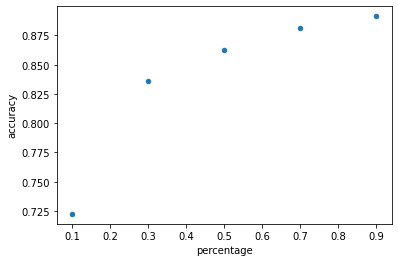

In [30]:
full_pct_data(0.7)

No of data - 54000

 Percentage is 10 

152/152 [==============================] - 1s 5ms/step - loss: 0.9672 - accuracy: 0.7492 - val_loss: 0.4946 - val_accuracy: 0.8611

 Percentage is 30 

456/456 [==============================] - 2s 4ms/step - loss: 0.5288 - accuracy: 0.8537 - val_loss: 0.3125 - val_accuracy: 0.9142

 Percentage is 50 

760/760 [==============================] - 3s 4ms/step - loss: 0.4353 - accuracy: 0.8741 - val_loss: 0.2556 - val_accuracy: 0.9311

 Percentage is 70 

1064/1064 [==============================] - 4s 4ms/step - loss: 0.3671 - accuracy: 0.8956 - val_loss: 0.2187 - val_accuracy: 0.9317

 Percentage is 90 

1367/1367 [==============================] - 5s 4ms/step - loss: 0.3165 - accuracy: 0.9121 - val_loss: 0.1554 - val_accuracy: 0.9586


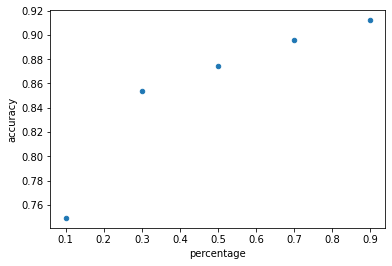

In [31]:
full_pct_data(0.9)

No of data - 60000

 Percentage is 10 

169/169 [==============================] - 1s 4ms/step - loss: 0.8846 - accuracy: 0.7724 - val_loss: 0.3900 - val_accuracy: 0.8883

 Percentage is 30 

507/507 [==============================] - 2s 4ms/step - loss: 0.5059 - accuracy: 0.8569 - val_loss: 0.2748 - val_accuracy: 0.9278

 Percentage is 50 

844/844 [==============================] - 3s 4ms/step - loss: 0.4166 - accuracy: 0.8844 - val_loss: 0.2414 - val_accuracy: 0.9327

 Percentage is 70 

1182/1182 [==============================] - 4s 4ms/step - loss: 0.3521 - accuracy: 0.8984 - val_loss: 0.2292 - val_accuracy: 0.9326

 Percentage is 90 

1519/1519 [==============================] - 6s 4ms/step - loss: 0.3101 - accuracy: 0.9145 - val_loss: 0.1690 - val_accuracy: 0.9487


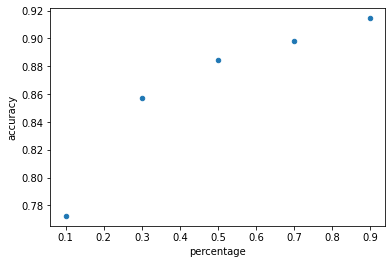

In [32]:
full_pct_data(1.0)